In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
import itertools
import warnings
warnings.simplefilter("ignore", UserWarning)


# Onsite and hoppings terms for BHZ and QAH model

def onsite_BHZ(site, p):
    return ((p.M - 4 * p.B) * pauli.s0sz - 4 * p.D * pauli.s0s0
            + p.field * site.pos[1] * pauli.s0s0)


def hopx_BHZ(site1, site2, p):
    return p.B * pauli.s0sz + p.D * pauli.s0s0 + 0.5j * p.A * pauli.szsx


def hopy_BHZ(site1, site2, p):
    return p.B * pauli.s0sz + p.D * pauli.s0s0 - 0.5j * p.A * pauli.s0sy


def weak_hopping_BHZ(site1, site2, p):
    return p.t_inter * np.eye(4)


def onsite_QAH(site, p):
    return (p.mu - 4 * p.B) * pauli.sz + p.field * site.pos[1] * pauli.s0


def hopx_QAH(site1, site2, p):
    return p.B * pauli.sz + 0.5j * p.A * pauli.sx


def hopy_QAH(site1, site2, p):
    return p.B * pauli.sz + 0.5j * p.A * pauli.sy


def weak_hopping_QAH(site1, site2, p):
    return p.t_inter * np.eye(2)

# Systems
def create_screw_system(L, W, H, xs=None, ys=None, ye=None, pbc=True, model='BHZ'):
    """ Create system with screw dislocation.

    Function creates system with a screw dislocation. 
    L, W, H are dimension of scattering region.
    L, W are dimension of cross section. 
    Leads are attached from top and bottom (0,0,1) direction.

    xs, ys, ye describes where disloaction is placed.
    """
    if model == 'BHZ':
        onsite, hopx, hopy, weak_hopping = onsite_BHZ, hopx_BHZ,  hopy_BHZ, weak_hopping_BHZ
    elif model == 'QAH':
        onsite, hopx, hopy, weak_hopping = onsite_QAH, hopx_QAH,  hopy_QAH, weak_hopping_QAH

    def shape(pos):
        (x, y, z) = pos
        return (0 <= x < L) and (0 <= y < W) and (0 <= z < H)

    def lead_shape(pos):
        (x, y, z) = pos
        return (0 <= x < L) and (0 <= y < W)

    # calling kwant
    lat = kwant.lattice.general(np.identity(3))
    sys = kwant.Builder()

    sym = kwant.TranslationalSymmetry((0, 0, 1))
    lead = kwant.Builder(sym)

    # scattering system
    sys[lat.shape(shape, (0, 0, 0))] = onsite
    sys[kwant.HoppingKind((1, 0, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, 1, 0), lat)] = hopy
    sys[kwant.HoppingKind((0, 0, 1), lat)] = weak_hopping

    # lead system
    lead[lat.shape(lead_shape, (0, 0, 0))] = onsite
    lead[kwant.HoppingKind((1, 0, 0), lat)] = hopx
    lead[kwant.HoppingKind((0, 1, 0), lat)] = hopy
    lead[kwant.HoppingKind((0, 0, 1), lat)] = weak_hopping

    # defining dislocation
    if xs is not None:
        for y in range(ys, ye):
            for z in range(H):
                del sys[lat(xs + 1, y, z), lat(xs, y, z)]

            del lead[lat(xs + 1, y, 0), lat(xs, y, 0)]
            lead[lat(xs + 1, y, z + 1), lat(xs, y, z)] = hopx

        for y, z in itertools.product(range(ys, ye), range(H - 1)):
            sys[lat(xs + 1, y, z + 1), lat(xs, y, z)] = hopx

    # adding periodic boundary conditions
    if pbc:
        for x in range(L):
            lead[lat(x, 0, 0), lat(x, W - 1, 0)] = hopy
            for z in range(H):
                sys[lat(x, 0, z), lat(x, W - 1, z)] = hopy

        for y in range(W):
            lead[lat(0, y, 0), lat(L - 1, y, 0)] = hopx
            for z in range(H):
                sys[lat(0, y, z), lat(L - 1, y, z)] = hopx

    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())

    return sys.finalized(), lead


def create_edge_dislocation_system(L, W, H, xs=None, ys=None, ye=None, pbc=True, model='BHZ'):
    """ Create system with edge dislocation.

    Function creates system with an edge dislocation. 
    L, W, H are dimension of scattering region.
    L, W are dimension of cross section. 
    Leads are attached from top and bottom (0,0,1) direction.

    xs, ys, ye describes where disloaction is placed.
    """
    if model == 'BHZ':
        onsite, hopx, hopy, weak_hopping = onsite_BHZ, hopx_BHZ,  hopy_BHZ, weak_hopping_BHZ
    elif model == 'QAH':
        onsite, hopx, hopy, weak_hopping = onsite_QAH, hopx_QAH,  hopy_QAH, weak_hopping_QAH

    def shape(pos):
        (x, y, z) = pos
        return (0 <= x < L) and (0 <= y < W) and (0 <= z < H)

    def lead_shape(pos):
        (x, y, z) = pos
        return (0 <= x < L) and (0 <= y < W)

    # Calling kwant
    lat = kwant.lattice.general(np.identity(3))
    sys = kwant.Builder()

    sym = kwant.TranslationalSymmetry((0, 0, 1))
    lead = kwant.Builder(sym)

    # scattering system
    sys[lat.shape(shape, (0, 0, 0))] = onsite
    sys[kwant.HoppingKind((1, 0, 0), lat)] = weak_hopping
    sys[kwant.HoppingKind((0, 1, 0), lat)] = hopy
    sys[kwant.HoppingKind((0, 0, 1), lat)] = hopx

    # lead system
    lead[lat.shape(lead_shape, (0, 0, 0))] = onsite
    lead[kwant.HoppingKind((1, 0, 0), lat)] = weak_hopping
    lead[kwant.HoppingKind((0, 1, 0), lat)] = hopy
    lead[kwant.HoppingKind((0, 0, 1), lat)] = hopx

    # defining disclocation
    if xs != None:
        for y in range(ys, ye):
            del lead[lat(xs, y, 0)]
            lead[lat(xs + 1, y, 0), lat(xs - 1, y, 0)] = weak_hopping

            for z in range(H):
                del sys[lat(xs, y, z)]
                sys[lat(xs + 1, y, z), lat(xs - 1, y, z)] = weak_hopping

    # periodic boundary conditions
    if pbc:
        for x in range(L):
            lead[lat(x, 0, 0), lat(x, W - 1, 0)] = hopy
            for z in range(H):
                sys[lat(x, 0, z), lat(x, W - 1, z)] = hopy

        for y in range(W):
            lead[lat(0, y, 0), lat(L - 1, y, 0)] = weak_hopping
            for z in range(H):
                sys[lat(0, y, z), lat(L - 1, y, z)] = weak_hopping

    # attaching leads
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())

    return sys.finalized(), lead


def get_densities(lead, momentum, param, model, sorting_mid=0.0):
    """ Calculate density of states in the lead at a given momentum. """
    coord = np.array([lead.pos(i) for i in range(lead.graph.num_nodes)])
    xy = coord[coord[:, 2] == 0][:, :-1]
    indxs_xy = np.lexsort(xy.T)
    xy = xy[indxs_xy, :]

    h, t = lead.cell_hamiltonian(
        args=[param]), lead.inter_cell_hopping(args=[param])
    h_k = lambda k: h + t * np.exp(-1j * k) + t.T.conj() * np.exp(1j * k)

    vals, vecs = np.linalg.eigh(h_k(momentum))

    if model == 'BHZ':
        num_orbital = 4
    if model == 'QAH':
        num_orbital = 2

    densities = np.linalg.norm(vecs.reshape(-1, num_orbital, len(vecs)), axis=1)**2

    indxs = np.argsort(abs(vals - sorting_mid))
    vals = vals[indxs]
    densities = densities[:, indxs]
    densities = densities[indxs_xy, :]

    L, W = int(np.max(xy[:, 0]) + 1), int(np.max(xy[:, 1]) + 1)
    twod_densities = np.zeros((W, L, densities.shape[1]))

    for coord, val in zip(xy, densities):
        i, j = np.array(coord, dtype=int)
        twod_densities[j, i, :] = val

    return twod_densities, vals


def get_spectrum_and_densities(sys_func, p, model, momentum, kwargs):
    sys, lead = sys_func(L=11, W=21, H=5, xs=4, ys=5, ye=16, model=model)
    spect = spectrum(lead, p, **kwargs)
    densities = get_densities(sys.leads[0], momentum, p, model)
    return spect, densities


def create_hm(sys_func, momentum, kwargs):
    parameters = {
        'BHZ': {'A': 1.0, 'B': 1.0, 'D': 0.0, 'M': 0.8},
        'QAH': {'A': 1.0, 'B': 1.0, 'D': 0.0, 'mu': 0.8}}

    p_BHZ = SimpleNamespace(field=.005, t_inter=-.1, **parameters['BHZ'])
    p_QAH = SimpleNamespace(field=.01, t_inter=-.1, **parameters['QAH'])

    spectrum_QAH, densities_QAH = get_spectrum_and_densities(sys_func, p_QAH, 'QAH', momentum, kwargs)
    spectrum_BHZ, densities_BHZ = get_spectrum_and_densities(sys_func, p_BHZ, 'BHZ', momentum, kwargs)

    hm_dict = {}
    for n in range(7):
        for model, density, spect in zip(['BHZ', 'QAH'], 
                                            [densities_BHZ, densities_QAH], 
                                            [spectrum_BHZ, spectrum_QAH]):
            hm_dict[n, model] = ((spect * 
                                 holoviews.Points((momentum, density[1][n])) * 
                                 holoviews.VLine(momentum)).relabel('Bandstructure') + 
                                 holoviews.Raster(density[0][:, :, n], label='{\left|\psi|}^2'))


    return holoviews.HoloMap(hm_dict, kdims=['n', 'model'])

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

#Table of Contents
* [Introduction: weak topological phases](#Introduction:-weak-topological-phases)
* [Crystallographic defects and topology](#Crystallographic-defects-and-topology)
* [The role of defect dimensionality](#The-role-of-defect-dimensionality)
* [The defect topological invariant](#The-defect-topological-invariant)
* [Electronic states in dislocations](#Electronic-states-in-dislocations)
* [Conclusions](#Conclusions)


# Introduction: weak topological phases

Taylor Hughes from the University of Illinois at Urbana-Champaign will describe the interplay between defects in crystals and weak topological insulators.

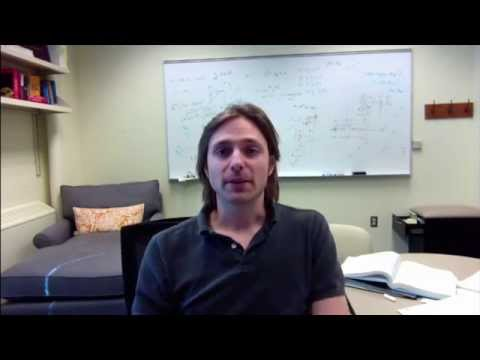

In [2]:
MoocVideo("k3ZKCg7jtTs", src_location="7.2-intro")

As you can see, there is a simple and universal connection between weak topological phases and the ability of defects to carry topologically protected states. The topological invariant $\mathcal{Q}$ of a dislocation is the number of protected states that it carries. It can be determined from the vector of weak topological invariants, $\mathbf{\mathcal{Q}}_\textrm{weak}$, and the Burgers vector of the dislocation $\mathbf{B}$:

$$\mathcal{Q} = \mathbf{\mathcal{Q}}_\textrm{weak}\cdot\mathbf{B}$$

Let us now go through the main points that lead to this conclusion, and argue for why it has to be that way.

# Crystallographic defects and topology

There are many different types of [defects in crystals](http://en.wikipedia.org/wiki/Crystallographic_defect): vacancies, substitutions, grain boundaries, dislocations, and many more.

What kinds of defects are important for topology? Consider a vacancy for example:
![](figures/Formation_Point_Defect.png)
(By Safe cracker (Own work) [CC BY 3.0 (http://creativecommons.org/licenses/by/3.0)], via Wikimedia Commons)

To create a vacancy, we need to remove a single atom (or all the atoms following one line). Can this type of defect carry a topologically protected state?

We already know that topological protection requires a Hamiltonian that cannot be created locally. For example, in order to create a single Majorana bound state at a phase boundary, another Majorana must appear elsewhere. Removing an atom or a line of atoms only changes the system locally, so the *other* topologically protected state cannot appear anywhere.

A simple vacancy is therefore not interesting from a topological point of view. What kinds of topological defects would work then? Crystallographic defects leave nothing different since they leave the bulk Hamiltonian unchanged far away from the defect core. This means we need to do something nontrivial to the crystal so that it cannot be removed locally.

Examples of such defects are dislocations:

![](figures/burgers_vectors.png)
(By David Gabriel García Andrade (Own work) [Public domain], via Wikimedia Commons)

In order to create a dislocation we need to cut a crystal along one plane and displace all the atoms along that plane by the *Burgers vector*. This has to be done all the way to the crystal boundary (or infinity in an infinite crystal), so the dislocation affects the entire system. This means that a dislocation cannot be removed locally.

As Taylor Hughes explained, a dislocation can be detected infinitely far from its core by going around it and verifying that we don't return to the point of origin. We cannot simply remove a dislocation by locally replacing some atoms. Therefore, it may carry a topologically protected mode.

Unsurprisingly, crystallographic defects that cannot be removed locally are called "topological", which brings us to the first important conclusion:

> *Topological* crystallographic defects are the ones that may carry topologically protected modes.

This is a non-trivial observation, even though it sounds tautological. There are two different types of topology involved: the topology of the electronic modes and the topology of the crystal.

# The role of defect dimensionality

When do topological defects carry protected edge states?

Far away from the defect, the bulk is homogeneous. Hence, the appearance of an edge state must be encoded both in the properties of the defect and in the bulk Hamiltonian. Of course, the appearance of this state must also be controlled by a topological invariant, since the protected state cannot disappear without the closing of the bulk gap.

What kind of topological invariant can this be? Can a strong topological invariant create a protected edge state at a defect?

In a sense we already know that it does. We can think of the crystal surface as a defect that breaks translational symmetry, and so it is a crystallographic defect. The strong topological invariant is the quantity that tells us whether or not the bulk can be continuously deformed into vacuum, or equivalently, whether or not the surface can be smoothly removed without closing the bulk gap.

In a $d$-dimensional bulk, the strong invariant is responsible for the appearance of a $d-1$-dimensional topologically protected state. This state can only be bound to a surface, which is the only $d-1$-dimensional topological defect. Defects of lower dimensionality can not be impacted by the strong invariant. An example of such a defect of lower dimensionality is precisely a dislocation, as in the previous figure. It is a one-dimensional defect in a three-dimensional crystal.

This is where the weak invariants come into play.

First of all, we know that the dimensionality $d_\textrm{egde}$ of a protected state at a defect must match the dimensionality of the defect. Secondly, we know the dimensionality of the topological invariant that controls this protected state: it is the topological invariant in the dimension $d_\textrm{edge}+1$.

The topological invariants with dimensionality $d_{edge}+1$ form a vector or a tensor of the weak indices. The last thing we need to figure out is how to extract information about what happens at the defect from the weak indices.

# The defect topological invariant

We have almost arrived at the criterion for the appearance of protected states in dislocations.

To see how the weak topological invariant relates to the number of states in the dislocation, we start by deforming a weak topological insulator into a set of disconnected planes, each carrying protected states. If there is a single state approaching the dislocation, as is shown in the figure below, it cannot backscatter and must therefore continue through the dislocation core.

![](figures/dislocation_helical.svg)

(adapted from Cdang (Own work), via Wikimedia Commons, [CC BY-SA 3.0](http://creativecommons.org/licenses/by-sa/3.0).)

Counting the number and the orientation of the crystal planes approaching the core of the dislocation is just the Burgers vector. Hence, the number of edge states entering the dislocation core is the Burgers vector times the number of states per crystal plane. This brings us to the conclusion:

$$\mathcal{Q} = \mathbf{\mathcal{Q}}_\textrm{weak}\cdot\mathbf{B}.$$

Let's now test this idea and see if we can observe the protected dislocation states.

# Electronic states in dislocations

Now that we know the main concepts, let's apply them to concrete examples. Let's take two models for topological insulators that we already know and apply them to lattice systems with dislocations.

We will create a 3D weak topological insulators by stacking many layers of 2D topological insulators along the $z$ direction. For the individual layers, we will use the BHZ model (by the way, note that the lecture today was given by the H of BHZ!) for a time-reversal invariant topological insulator, and the square lattice model for the quantum Hall effect that we used in week 4. In this way, we can study dislocations both with and without time reversal symmetry. In both cases, we take the hoppings between different layers to be relatively weak compared to those within the same layer.

Let's start with a screw dislocation connecting two layers. The system looks like this:

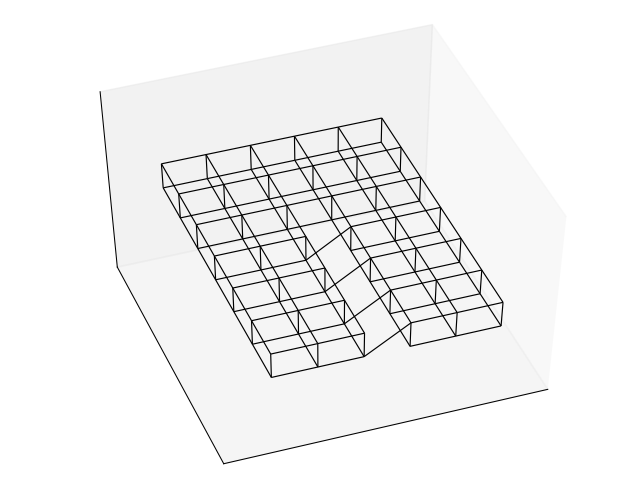

In [3]:
# System parameters
L = 6
W = 7
ws = 3
xs = 2
sys, lead = create_screw_system(L, W, 2, xs=xs, ys=0, ye=W-ws, pbc=False, model='BHZ')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
kwant.plot(sys, site_size=0.0, site_lw=0.01, hop_lw=0.025, ax=ax, num_lead_cells=0);

ax.set_xticks(())
ax.set_yticks(())
ax.set_zticks(())
ax.view_init(50,-110)

The Burgers' vector is parallel to $z$ and has unit length - the dislocation connects neighboring layers.

The figure above only shows two layers, but we imagine that the system is repeated identically along the $z$ direction. Along the $x$ and $y$ directions it has periodic boundary conditions. Above we only show half of the dislocation.

Let's look at the band structure along the $z$ direction, and the wave functions of the corresponding states.

:Layout
   .Overlay.Bandstructure                                                                                                :HoloMap   [n,model]
      :Overlay
         .Path.I   :Path   [$k_x$,$E$]
         .Points.I :Points   [x,y]
         .VLine.I  :VLine   [x,y]
   .Raster.Left_curly_bracket_reverse_over_left_vertical_line_reverse_over_psi_vertical_line_right_curly_bracket_power_2 :HoloMap   [n,model]
      :Raster   [x,y]   (z)
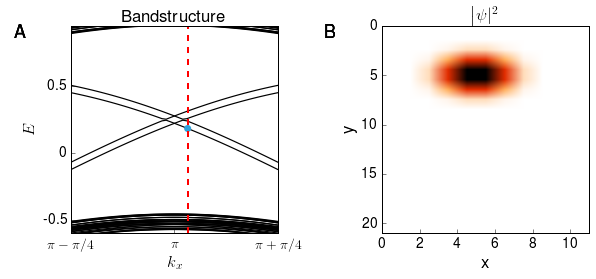
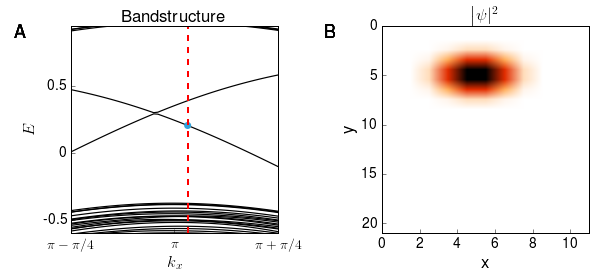
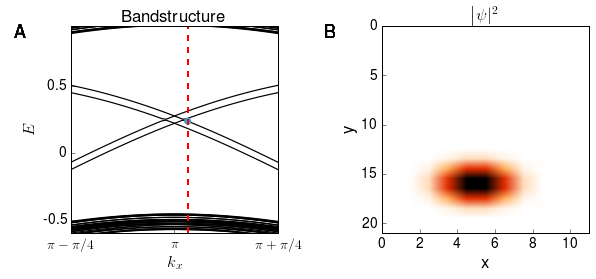
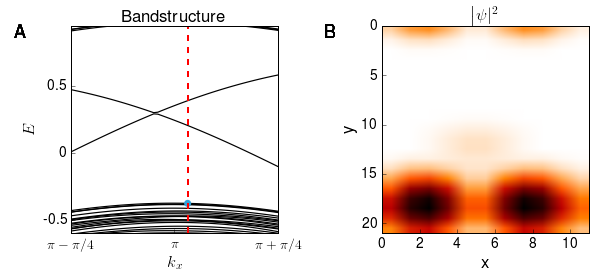
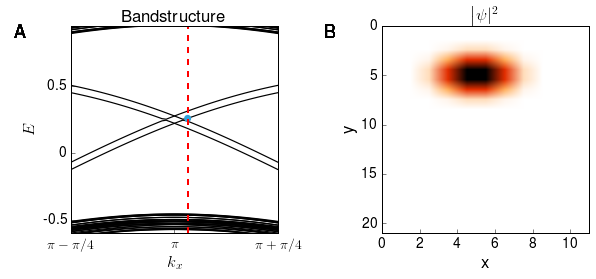
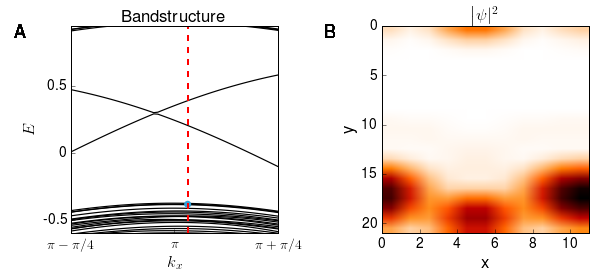
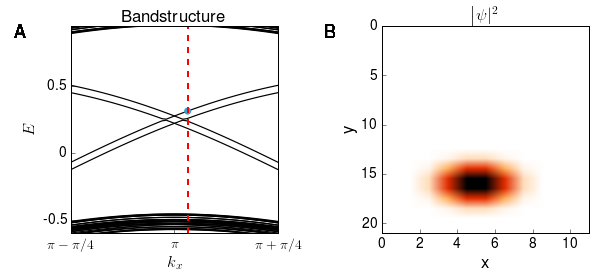
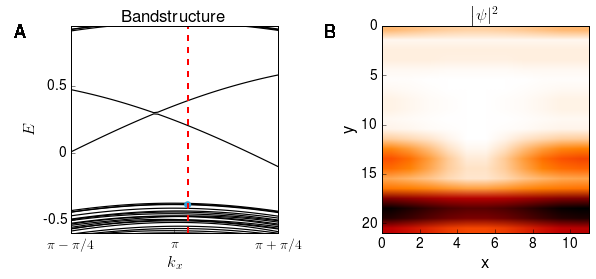
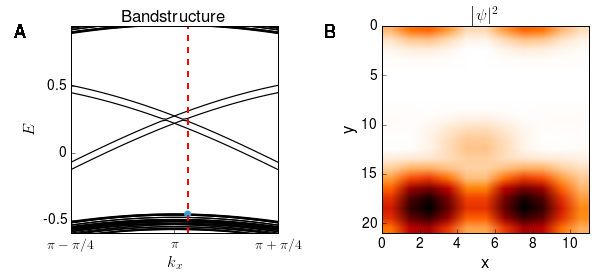
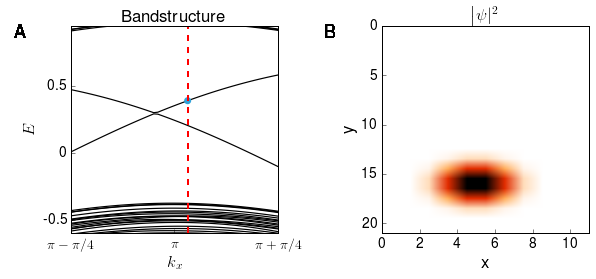
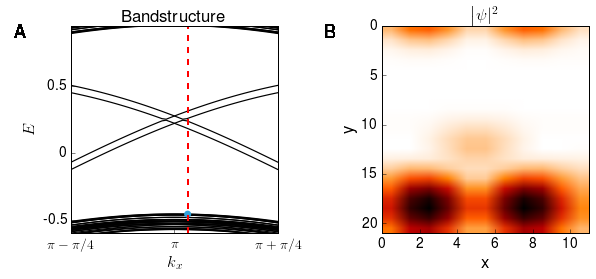
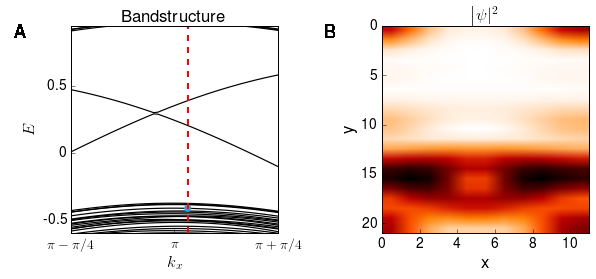
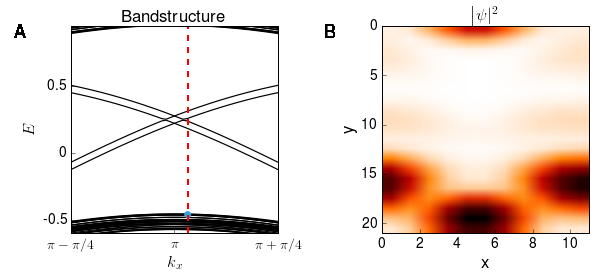
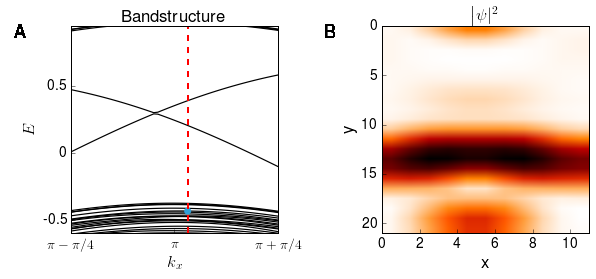

In [4]:
%opts Raster(cmap='gist_heat_r' interpolation=None) {+framewise}
%opts Points(s=50)

kwargs = {'k_x': np.linspace(np.pi - np.pi / 4, np.pi + np.pi / 4, 51),
          'ylims': [-0.6, 0.95],
          'yticks': [-0.5, 0, 0.5],
          'xticks': [(np.pi - np.pi / 4, r'$\pi-\pi/4$'), (np.pi, r'$\pi$'), (np.pi + np.pi / 4, r'$\pi+\pi/4$')]}

create_hm(create_screw_system, momentum=np.pi + 0.1, kwargs=kwargs).collate()

You see that the band structure is gapless: because of the presence of the dislocation, there are states dispersing below the bulk gap along the $z$ direction.

A look at their wave functions in the right panel shows that in the $x$-$y$ plane, these low-energy states are localized around the end points of the dislocation (we show the wave function corresponding to the blue dot in the band structure plot). On the other hand, when you look at the wave function of states above the gap, you see that they are spread out the whole $x$-$y$ plane.

Here, the fundamental difference between the BHZ model and the quantum anomalous Hall case is that in the former, the gapless states at the dislocation are helical, while in the latter they are chiral.

We can also look at an edge dislocation:

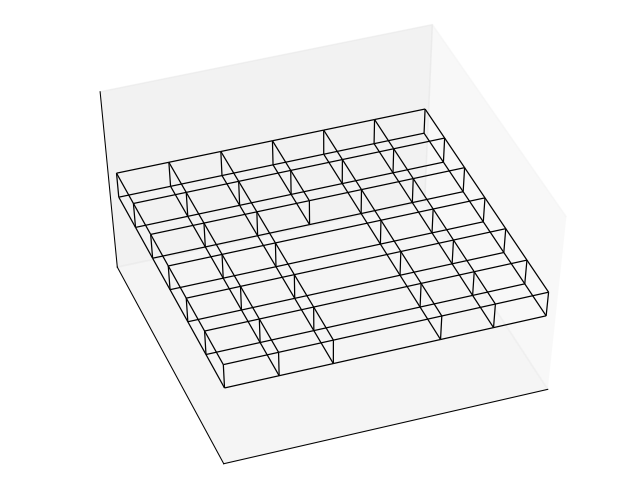

In [5]:
# System parameters
L = 7
W = 7
ws = 3
xs = 3
sys, lead = create_edge_dislocation_system(L, W, 2, xs=xs, ys=0, ye=W - ws, pbc=False, model='BHZ')


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

kwant.plot(sys, site_size=0.0, site_lw=0.01, hop_lw=0.025, ax=ax, num_lead_cells=0)

ax.set_xticks(())
ax.set_yticks(())
ax.set_zticks(())
ax.view_init(50, -110)

The Burgers vector is now along the $y$ direction, and it still has unit length. The band structure and the wave function plots show similar behavior.

:Layout
   .Overlay.Bandstructure                                                                                                :HoloMap   [n,model]
      :Overlay
         .Path.I   :Path   [$k_x$,$E$]
         .Points.I :Points   [x,y]
         .VLine.I  :VLine   [x,y]
   .Raster.Left_curly_bracket_reverse_over_left_vertical_line_reverse_over_psi_vertical_line_right_curly_bracket_power_2 :HoloMap   [n,model]
      :Raster   [x,y]   (z)
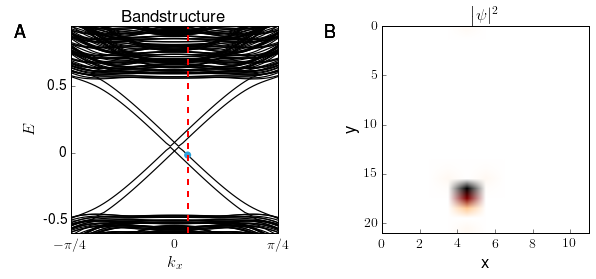
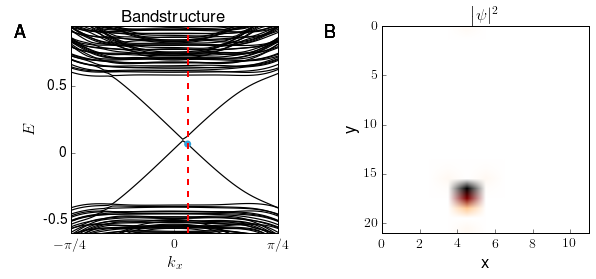
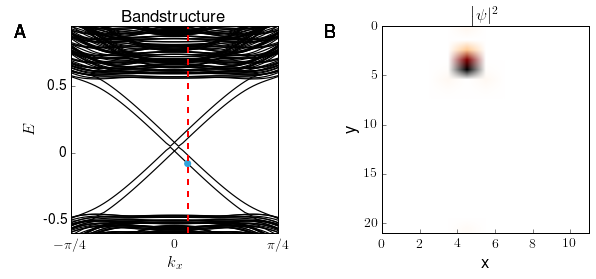
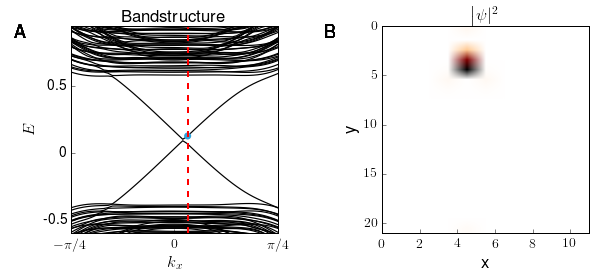
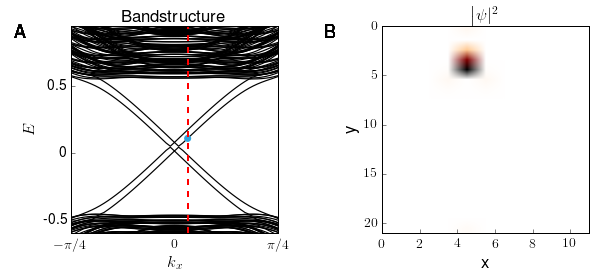
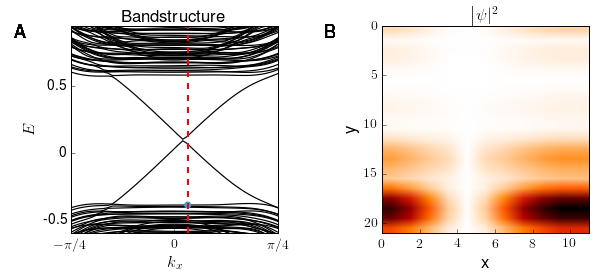
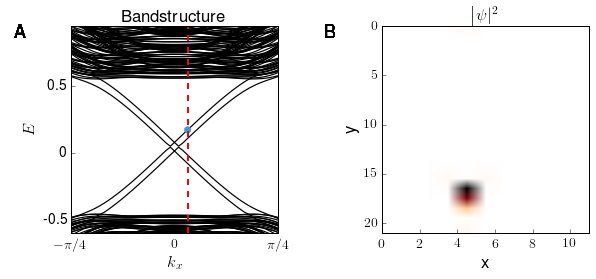
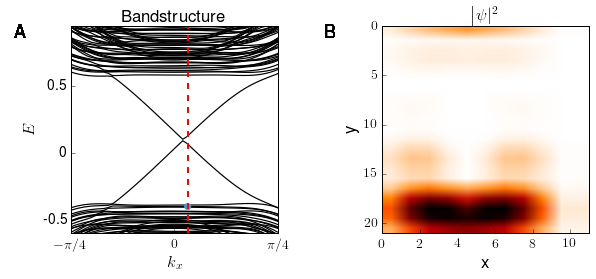
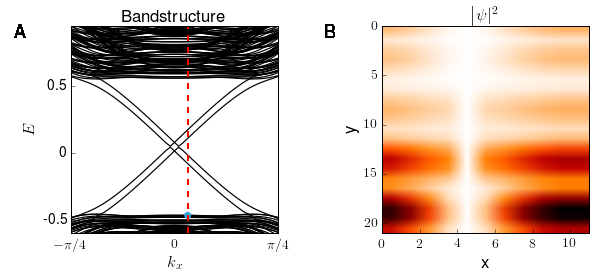
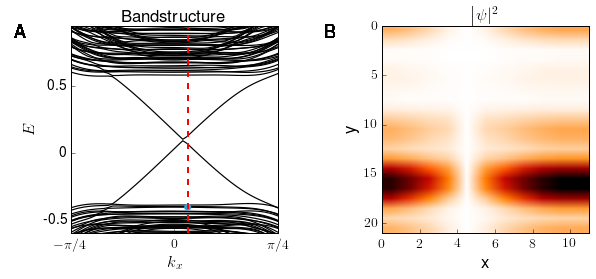
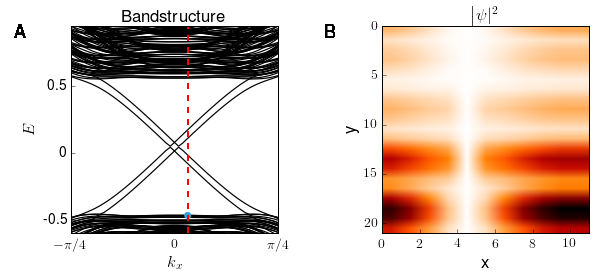
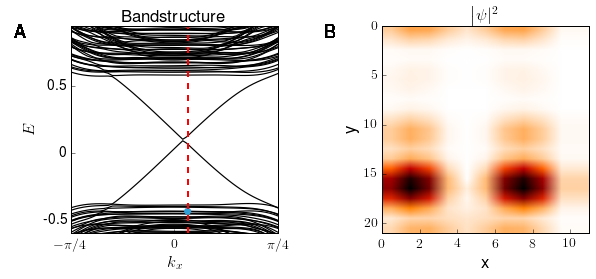
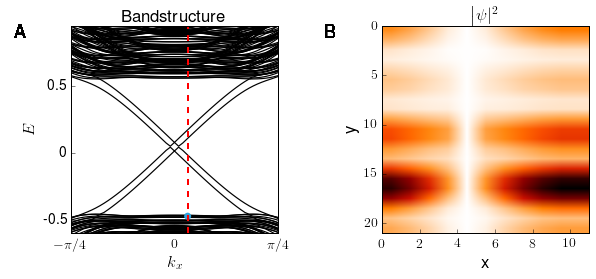
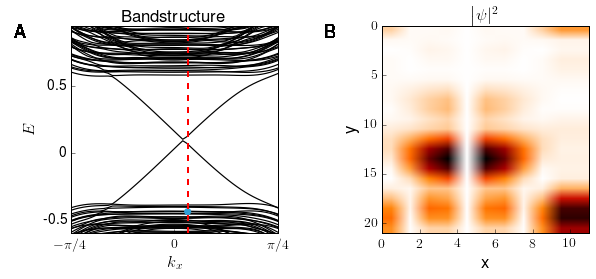

In [6]:
%opts Raster(cmap='gist_heat_r' interpolation=None) {+framewise}
%opts Points(s=50)

kwargs = {'k_x': np.linspace(-np.pi / 4, np.pi / 4, 51),
          'ylims': [-0.6, 0.95],
          'yticks': [-0.5, 0, 0.5],
          'xticks': [(-np.pi / 4, r'$-\pi/4$'), (0, r'$0$'), (np.pi / 4, r'$\pi/4$')]}

create_hm(create_edge_dislocation_system, momentum=0.1, kwargs=kwargs).collate()

In [7]:
question = ("What would happen in both simulations above if we changed the dislocation, "
            "making the Burgers vector twice as long?")

answers = ["The wave function would just spread out a bit more because the dislocation is larger.",
           "The number of gapless states would double for both models.",
           "The gapless states would be gapped out for both models.",
           "The dislocation would only have gapless states in the quantum anomalous Hall case, not for the BHZ model."]

explanation = ("Doubling the Burgers vector doubles the topological invariant in the $\mathbb{Z}$ case, "
               "and changes it from non-trivial to trivial in the $\mathbb{Z}_2$ case.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=3, explanation=explanation)

MoocMultipleChoiceAssessment(**{'max_attempts': 2, 'explanation': 'Doubling the Burgers vector doubles the topological invariant in the $\\mathbb{Z}$ case, and changes it from non-trivial to trivial in the $\\mathbb{Z}_2$ case.', 'question': 'What would happen in both simulations above if we changed the dislocation, making the Burgers vector twice as long?', 'answers': ['The wave function would just spread out a bit more because the dislocation is larger.', 'The number of gapless states would double for both models.', 'The gapless states would be gapped out for both models.', 'The dislocation would only have gapless states in the quantum anomalous Hall case, not for the BHZ model.'], 'display_name': 'Question', 'correct_answer': 3})

# Conclusions

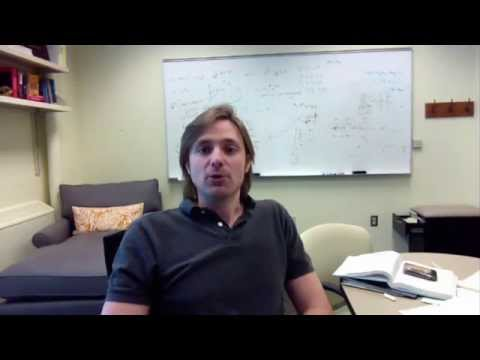

In [8]:
MoocVideo("MvcvJiZYSSk", src_location="7.2-summary")

Questions about what you just learned? Ask them below!

In [9]:
MoocDiscussion("Questions", "Crystalline defects")

MoocDiscussion(**{'discussion_target': 'Crystalline defects', 'discussion_category': 'Questions', 'discussion_id': '3dfd5aa4f385022f0afc808bbf8f4caa', 'display_name': 'Crystalline defects'})